# Deep Learning - Winter Term 2024/2025

<hr style="border:2px solid gray">

### Exercise Sheet 03

<br>

## 4.2 Train a CNN on CIFAR10

Finally we deal with a more challenging task -- CIFAR10. It is a dataset consisting of RGB pictures of objects. Thankfully, CIFAR is also a popular dataset and can be donwloaded using Torchvision just like MNIST.

__General remark:__ We suggest you to go through the code and understand what this exercise is about before coding. You might find some tasks that come later easier than the previous tasks and solving them could give you better understanding.

__Note:__ CIFAR10 is a large dataset and training needs much computation power. Therefore it is recommended to use [Google Colab](https://colab.research.google.com).

Without further ado, let's get to it!

In [ ]:
# We start with importing some necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import time

# A lot of PyTorch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.utils import make_grid
from torchvision import datasets
from torchvision.transforms import v2

In [ ]:
# TODO: Implement the __init__ and forward method of the CNN class.
# Here are some hints you should take into account
#     - As you learned in the lecture, typically fully-connected layers
#       follow the convolution blocks. So do not forget to flatten the appropriate dimension
#       A linear layer expects input size (B, H), where B is batch size and H is feature size.
#       Check the PyTorch documentation for details.
#     - Our aim is to learn different regularization strategies. You can try any methodlogy
#       that seems reasonable to you *but* Dropout is highly recommended in this setting.
#     - We will use the negative log-likelihood as the loss function, keep it in mind
#       when choosing the output function.
#     - Which activation function you choose can be decisive here.


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # TODO: initialize the layers here
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.residual_conv1 = nn.Conv2d(3, 64, kernel_size=1)
        self.residual_conv2 = nn.Conv2d(64, 256, kernel_size=1)
        self.dropout = nn.Dropout(0.4)  # Increased dropout for regularization

    def forward(self, x):
        # First two layers with residual connection
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        # Fix: Add a 1x1 convolution to match the number of channels
        residual = self.residual_conv1(residual)  # Using the layer defined in __init__
        x = x + residual  # Add residual connection
        x = self.pool(x)

        # Next two layers with residual connection
        residual = x
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        # Fix: Add a 1x1 convolution to match the number of channels
        residual = self.residual_conv2(residual)
        x = x + residual  # Add residual connection
        x = self.pool(x)

        # Last layer (no residual since it's the last conv layer)
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)

        # Fully connected layers
        x = x.view(-1, 512 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x



In [ ]:
# We can test if the forward pass runs smoothly
# Following chunk should print torch.Size([1, 10])
t = torch.randn(1,3,32,32)
model = CNN()
model(t).shape

torch.Size([1, 10])

### Data preprocessing
In the following, we will download and preprocess the dataset. This process **do not** have to be done after implementing the model architecture. It solely depends on your thought flow.

In [ ]:
# In the first step, we find the mean and standard deviation of the training data.
# We would like to normalize these stats to ensure a nice network flow.

# Download the training dataset
ds_train = datasets.CIFAR10('./data', train=True, download=True)   # At this point, the ds_train object holds the entire CIFAR-10 training dataset (images and labels),
# Take only the images
ims_train = torch.tensor(ds_train.data)                            # ds_train.data: This accesses the raw image data in the dataset(with out labels).(and this to access the labels "labels_train = torch.tensor(ds_train.targets)")
ims_train = ims_train.float() / 255.

100%|██████████| 170M/170M [00:03<00:00, 42.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


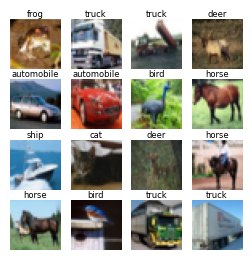

In [ ]:
# Let's look at the data. It is always a good idea to know what is in the dataset.
labels = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}
fig, ax = plt.subplots(4,4,figsize=(3,3))
for i, c_ax in enumerate(ax.flatten()):
    im, lab = ds_train[i]
    c_ax.imshow(im)
    c_ax.set_title(labels[lab],fontsize=6, y=0.88)
    c_ax.axis('off')

In [ ]:
# TODO: compute the mean and std
# Hint: we need the stats of each channel.
#       So, it should be three dimensional.
# mu, std = ...

mu = ims_train.mean(dim=(0, 1, 2))  # Mean across all images (dim=0) and pixels (dim=1, 2) for each channel
std = ims_train.std(dim=(0, 1, 2))  # Standard deviation across all images (dim=0) and pixels (dim=1, 2) for each channel


We are approaching to finalize the preprocessing. Following is an important step to make our model more generalizable. We will manipulate the data in order to create more '''diversity''' in the data. Especially, we want to make use of data augmentation. Torchvision has many different pre-implemented augmentation methodologies. Here is a nice starter in the documentation:

[Getting started with Transforms v2](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py)

In [ ]:
# TODO: Apply data augmentation using transforms v2.
#
# Training data:
#   - Apply a random crop with size 32 on a padded version of the image with p=4
#   - Flip each image 40% horizontally
#   - Transform to a Image
#   - Normalize with the constants calculated above
# Test data:
#   - Transform to a Tensor
#   - Normalize with the constants calculated above
#
# Please also add "v2.ToDtype(torch.float32, scale=True)"
# as it is shown in the starter text. It is needed.
#
# Finally build train and test dataloaders with batch size 128 and 2 workers
# We shuffle the traning set to exploit the stochasticity


# TODO: Implement the augmentation here
# Training transformations
v2_train = v2.Compose([
    v2.Pad(4),  # Pad the image by 4 pixels on all sides
    v2.RandomCrop(32),  # Random crop to 32x32 after padding
    v2.RandomHorizontalFlip(p=0.4),  # Flip image horizontally with 40% probability
    v2.ToTensor(),  # Convert the image to a PyTorch tensor
    v2.Normalize(mean=mu, std=std),  # Normalize using the calculated mean and std
    v2.ToDtype(torch.float32, scale=True)  # Convert the tensor to float32 and scale to [0, 1]
])

# Test transformations
v2_test = v2.Compose([
    v2.ToTensor(),  # Convert the image to a PyTorch tensor
    v2.Normalize(mean=mu, std=std),  # Normalize using the calculated mean and std
    v2.ToDtype(torch.float32, scale=True)  # Convert the tensor to float32 and scale to [0, 1]
])

ds_train = datasets.CIFAR10('./data', train=True, download=True, transform=v2_train)
ds_test = datasets.CIFAR10('./data', train=False, download=True, transform=v2_test)

# Here we can look at the data size. They are huge!
print(f'Train data -> {ds_train.data.shape}')
print(f'Test data -> {ds_test.data.shape}')


# Implement the dataloaders here
# DataLoader for training set with batch size 128 and 2 workers for parallel loading
dl_train = DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=2)

# DataLoader for test set with batch size 128 and 2 workers
dl_test = DataLoader(ds_test, batch_size=128, shuffle=False, num_workers=2)


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Train data -> (50000, 32, 32, 3)
Test data -> (10000, 32, 32, 3)


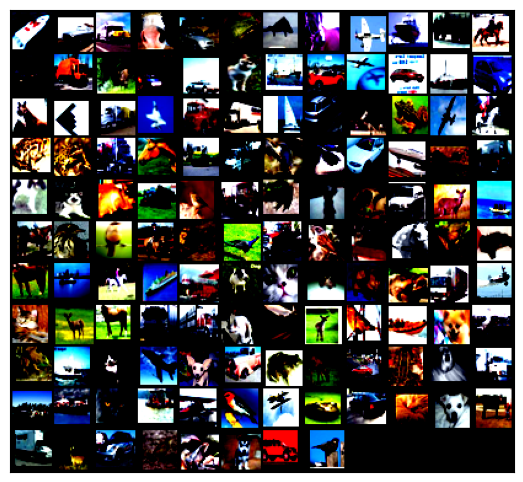

In [ ]:
# We can now look into the augmented data.
for images, labels in dl_train:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=12).permute(1, 2, 0))
        break

Almost there! We only need to code the training and test loops. Note that this implementation is slightly different than the previous exercise. This time we will wrap the training and testing process in a method and call the methods for each epoch. We provide you ```test``` but you need to complete the ```train```method.

In [ ]:
def test(model, dl_test, criterion, device='cuda'):
    """
    model: model to test
    dl_test: test data
    criterion: loss function
    device: device to test on
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # no need to track gradients. Saves memory.
        for images, labels in dl_test:
            images, labels = images.to(device), labels.to(device)
            output = model(images) # Forward pass
            test_loss += criterion(output, labels).item()  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).sum() # get the correct predictions

    test_loss /= len(dl_test.dataset)
    accuracy = 100. * correct / len(dl_test.dataset)

    print('\nTest set - Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(dl_test.dataset),
        accuracy.item()))

In [ ]:
# TODO: Implement the train method
# You basically need to implement the common training block

def train(model, dl_train, optimizer, epoch, criterion, log_interval=100, device='cuda'):
    """
    model: model to train
    dl_test: train data
    optimizer: optimization algorithm
    epoch: current epoch
    criterion: loss function
    log_interval: printing interval
    device: device to train on
    """
    model.train()
    correct = 0
    total = 0
    train_loss = 0.
    for batch_idx, (images, labels) in enumerate(dl_train):
        images, labels = images.to(device), labels.to(device)

        #TODO: Implement the training block here

        # Zero out the gradients (PyTorch accumulates gradients by default)
        optimizer.zero_grad()

        # Forward pass: Get predictions from the model
        output = model(images)

        # Calculate the loss between the predicted output and the actual labels
        loss = criterion(output, labels)

        # Backward pass: Calculate gradients
        loss.backward()

        # Update model parameters using the optimizer
        optimizer.step()

        # Get some statistics
        train_loss += loss.detach().item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(labels.data.view_as(pred)).sum()
        # Fix: Get the batch size from the images tensor
        batch_size = images.size(0)
        total += batch_size
        train_acc = 100 * correct / total

        if batch_idx % log_interval == 0:
            print(f"Epoch {epoch + 1}/{batch_idx + 1} -> {train_loss / (batch_idx + 1)} --- acc -> {train_acc}%")


Yee-haw! Finally we can train our model!

In [ ]:
# Seed for reproducibility
torch.manual_seed(4321)

# Initialize the model
model = CNN()
model.to(device)

# TODO: initialize the optimizer.
#   - Use SGD with momentum
#   - Apply L2 penalty
# optimizer = ...
# Initialize the optimizer (SGD with momentum and L2 regularization)
optimizer = torch.optim.SGD(
    model.parameters(),            # Parameters to optimize (model's weights)
    lr=0.01,                       # Learning rate
    momentum=0.9,                  # Momentum
    weight_decay=5e-4              # L2 regularization (weight decay)
)

# TODO: set criterion
# criterion = ...
criterion = torch.nn.CrossEntropyLoss()

# Following code applies a learning rate schedule such that it changes after each epoch.
# It is pre-implemented in torch.optim. Pretty neat, huh?
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
# run()
a = time.time()

epochs = 5
for epoch in range(epochs):
    train(model, dl_train, optimizer, epoch, criterion, log_interval=50)
    test(model, dl_test, criterion)
    scheduler.step()

b = time.time()
print('\nTraining took ' + str(np.round(b - a, 2)) + ' seconds.\n\n')

Epoch 1/1 -> 2.3036303520202637 --- acc -> 6.25%
Epoch 1/51 -> 2.0466431846805646 --- acc -> 23.651962280273438%
Epoch 1/101 -> 1.8847776474338946 --- acc -> 29.432239532470703%
Epoch 1/151 -> 1.7872824874145306 --- acc -> 33.314361572265625%
Epoch 1/201 -> 1.719202607425291 --- acc -> 35.980255126953125%
Epoch 1/251 -> 1.664082116339786 --- acc -> 38.13496017456055%
Epoch 1/301 -> 1.6176815583460356 --- acc -> 39.98390579223633%
Epoch 1/351 -> 1.5785107222038117 --- acc -> 41.55315017700195%

Test set - Average loss: 0.0097, Accuracy: 5569/10000 (55.690%)

Epoch 2/1 -> 1.2338029146194458 --- acc -> 56.25%
Epoch 2/51 -> 1.2400498577192718 --- acc -> 54.82537078857422%


KeyboardInterrupt: 

This should give us around $35-40\%$ accuracy. The performance is a lot better than random, but we can definitely increase it. Before doing that, if you are not already on Google Colab, you probably realize that your machine is stressed out and the training took much time. Let us now use a GPU and see how much difference it makes. If available, you can use the one in your computer. If not, you can just move to Colab.

On Colab, to use a GPU, follow on the collaboratory menu tabs, "Runtime" -> "Change runtime type" and set it to GPU. Then run the same training loop but now on GPU.

**Note:** There are no TODOs in this part. It is just about the speed.

In [ ]:
# Let's speed up!
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # additional speed up

model = CNN().to(device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=5e-4
)

criterion = torch.nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
model = model.to(device)

In [ ]:
# run()
a = time.time()

epochs = 80
for epoch in range(epochs):
    train(model, dl_train, optimizer, epoch, criterion, log_interval=50)
    test(model, dl_test, criterion)
    scheduler.step()

b = time.time()
print('\nTraining took ' + str(np.round(b - a, 2)) + ' seconds.\n\n')

Epoch 1/1 -> 2.3059909343719482 --- acc -> 7.03125%
Epoch 1/51 -> 2.042869724479376 --- acc -> 24.06556510925293%
Epoch 1/101 -> 1.8733811425690603 --- acc -> 29.826732635498047%
Epoch 1/151 -> 1.7727461626987584 --- acc -> 33.60927200317383%
Epoch 1/201 -> 1.7048676695989733 --- acc -> 36.31452178955078%
Epoch 1/251 -> 1.6467302491465412 --- acc -> 38.54270553588867%
Epoch 1/301 -> 1.5999555500638842 --- acc -> 40.40957260131836%
Epoch 1/351 -> 1.558453376816209 --- acc -> 42.09624099731445%

Test set - Average loss: 0.0091, Accuracy: 5755/10000 (57.550%)

Epoch 2/1 -> 1.4135388135910034 --- acc -> 47.65625%
Epoch 2/51 -> 1.1996695130479103 --- acc -> 56.11213302612305%
Epoch 2/101 -> 1.1739039763365642 --- acc -> 57.67326736450195%
Epoch 2/151 -> 1.157997050822176 --- acc -> 58.148799896240234%
Epoch 2/201 -> 1.1491382445268963 --- acc -> 58.35276794433594%
Epoch 2/251 -> 1.1334587660918674 --- acc -> 59.116661071777344%
Epoch 2/301 -> 1.1181132141933885 --- acc -> 59.73318099975586%

This should be way faster now. The fact that we can train the model faster does not only save us time. More importantly, it allows us to scale up the models and still train them in a reasonable amount of time. Now it is time to increase the performence as well.

Again, PyTorch is very helpful. We can just initialize a state-of-the-art model and train it. You will learn this model in the lecture.

In [ ]:
from torchvision.models import resnet18

In [ ]:
model = resnet18()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Looks massive but it is a highly efficient model that implements a very simple idea, i.e. **the residual block**. However, these models are developed for Imagenet dataset, which has $1000$ classes. So we need to adapt the output layer of the model.

Currently the last layer is:
```
  (fc): Linear(in_features=512, out_features=1000, bias=True)
```

In [ ]:
# TODO: Adapt ResNet to train on CIFAR10
model.fc = torch.nn.Linear(in_features=512, out_features=10, bias=True)

In [ ]:
# Let's speed up!
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # additional speed up



optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

criterion = torch.nn.CrossEntropyLoss()


scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
model = model.to(device)

In [ ]:
# run()
a = time.time()

epochs = 80
for epoch in range(epochs):
    train(model, dl_train, optimizer, epoch, criterion, log_interval=50)
    test(model, dl_test, criterion)
    scheduler.step()

b = time.time()
print('\nTraining took ' + str(np.round(b - a, 2)) + ' seconds.\n\n')

Epoch 1/1 -> 0.7064217925071716 --- acc -> 76.5625%
Epoch 1/51 -> 0.6854229709681343 --- acc -> 76.5625%
Epoch 1/101 -> 0.6714608928944805 --- acc -> 77.03433990478516%
Epoch 1/151 -> 0.6718262428084746 --- acc -> 77.03331756591797%
Epoch 1/201 -> 0.6660565770977173 --- acc -> 77.24657440185547%
Epoch 1/251 -> 0.6603003425664635 --- acc -> 77.356201171875%
Epoch 1/301 -> 0.6542438029054788 --- acc -> 77.6785659790039%
Epoch 1/351 -> 0.6491995331568595 --- acc -> 77.91799926757812%

Test set - Average loss: 0.0051, Accuracy: 7757/10000 (77.570%)

Epoch 2/1 -> 0.618499755859375 --- acc -> 82.8125%
Epoch 2/51 -> 0.5960174898306528 --- acc -> 80.17769622802734%
Epoch 2/101 -> 0.6005360678871079 --- acc -> 79.78805541992188%
Epoch 2/151 -> 0.6041271274058234 --- acc -> 79.58919525146484%
Epoch 2/201 -> 0.610292297690662 --- acc -> 79.31047821044922%
Epoch 2/251 -> 0.6084231184535768 --- acc -> 79.31710815429688%
Epoch 2/301 -> 0.6077444550404913 --- acc -> 79.36565399169922%
Epoch 2/351 -> 

Now, we should reach over $50\%$. Is it good? Actually, we can do it even better!

***Bonus exercise:*** Achieve test accuracy $>90$. You can change many things to reach this performence (e.g. architecture, optimizer, regularization methods, different hyperparameters).